###  导包

In [1]:
import re # 正则
import jieba # jieba分词工具
import emoji # 处理表情
import pickle # 序列化保存工具
import pandas as pd # 数据处理
import numpy as np # 数学运算
import matplotlib.pyplot as plt # 画图工具
from pyecharts import options as opts # options类
from pyecharts.charts import Pie # 饼图
from pyecharts.render import make_snapshot # html转png
from snapshot_selenium import snapshot # html转png
from gensim import corpora,models # 主题模型
from snownlp import SnowNLP,sentiment # 情感分析

### 相关画图参数配置及函数定义

In [2]:
# 函数的作用：在柱状图上标记其数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
# 画图的全局参数配置
plt.rcParams['font.sans-serif'] = ['SimHei'] # 黑体
plt.rcParams['font.size'] = 15 # 字号为15
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题

### LDA主题模型

训练及保存模型、保存评论划分的主题结果

In [3]:
def process(s):
    _=set() # 表情集合
    for i in emoji.emoji_lis(s):
        _.add(emoji.UNICODE_EMOJI.get(i['emoji']))
    emo=[emoji.emojize(i) for i in list(_)]
    w=re.sub('&[a-zA-Z]+;|<br/>|电池续航：|拍照效果：|显示效果：|运行速度：|外形外观：|屏幕音效：|其他特色：|通信音质：|待机时间：','',s)
    w=w.lower()
    temp=jieba.lcut(w) # 分词
    result=[]
    for i in temp:
        if (i not in stoplist) and (re.search('[^\u4e00-\u9fa50-9a-zA-Z]+',i) is None): # 去除停用词
            result.append(i)
    result=result+emo
    return ' '.join(result)

def LDA(flag=False):
    # 加载自定义词典
    jieba.load_userdict('./data/dict.txt')
    # 增加词语
    ws=['天空之境','亮黑色','极光色','珠光贝母','赤茶橘','墨玉蓝','嫣紫色','差评','中评','京东商城','苏宁易购','华为商城']
    for i in ws:
        jieba.add_word(i)
    temp=comments[1].apply(lambda x:x.split())
    data=corpora.Dictionary(temp) # 构建dictionary
    data_corpus=[data.doc2bow(i) for i in temp] # 构建corpus
    lda_model=models.LdaModel(data_corpus,num_topics=5,id2word=data,passes=30) # 训练LDA主题模型，其中：主题数为5，迭代30次
    if flag:
        # 序列化保存模型
        pickle.dump(data_corpus, open('./data/LDA/corpus.pkl', 'wb'))
        data.save('./data/LDA/dictionary.gensim')
        lda_model.save('./data/LDA/lda.gensim')
    return data,data_corpus,lda_model

stop_file=open('./data/stoplist.txt','r',encoding='utf-8')
stoplist=[i.strip() for i in stop_file.readlines()] # 停用词表
stop_file.close()

comments=pd.read_csv('./data/sentences.txt',header=None)
comments[1]=comments[0].apply(lambda s:process(s))
all_comments=comments.copy()
# 去掉分词后只有两个词以下的评论
comments=comments[comments[1].apply(lambda x:len(x.split())>2)==True]
comments.index=list(range(len(comments)))
data,data_corpus,lda_model=LDA(flag=True)
# 将得到主题模型应用于所有评论，得到每条评论对应的最大概率的主题
all_comments[2]=all_comments[1].apply(lambda x:lda_model.get_document_topics(data.doc2bow(x.split())))
topic_names={0:'主题一',1:'主题二',2:'主题三',3:'主题四',4:'主题五'}
all_comments[3]=all_comments[2].apply(lambda x:topic_names.get(np.argmax([j for i,j in x])))
columns=['原评论','分词处理后的评论','各主题得分概率','所属主题']
all_comments.columns=columns
# 保存结果
all_comments.to_csv('./data/LDA主题模型结果.csv',index=False,encoding='utf_8_sig')

Building prefix dict from the default dictionary ...
Dumping model to file cache D:/python3.7/jieba.cache
Loading model cost 1.333 seconds.
Prefix dict has been built succesfully.


重新加载数据、LDA主题模型，并查看各个主题前30个特征词及对应概率

In [4]:
# 加载LDA主题模型
data_corpus=pickle.load(open('./data/LDA/corpus.pkl', 'rb'))
data=corpora.Dictionary.load('./data/LDA/dictionary.gensim')
lda_model=models.ldamodel.LdaModel.load('./data/LDA/lda.gensim')

f=open('./data/LDA主题模型结果.csv',encoding='utf-8')
all_comments=pd.read_csv(f)
f.close()
all_comments=all_comments.fillna('')

hehe=lda_model.print_topics(num_topics=5, num_words=30)
hehe

[(0,
  '0.060*"手机" + 0.051*"拍照" + 0.044*"不错" + 0.038*"喜欢" + 0.030*"手感" + 0.023*"流畅" + 0.020*"漂亮" + 0.019*"功能" + 0.018*"好看" + 0.016*"超级" + 0.015*"外观" + 0.015*"特别" + 0.014*"颜色" + 0.014*"真的" + 0.012*"满意" + 0.011*"运行" + 0.011*"速度" + 0.011*"强大" + 0.011*"效果" + 0.011*"颜值" + 0.010*"棒" + 0.010*"清晰" + 0.010*"很漂亮" + 0.009*"照相" + 0.009*"老婆" + 0.009*"感觉" + 0.008*"高" + 0.008*"很快" + 0.008*"充电" + 0.007*"好用"'),
 (1,
  '0.184*"华为" + 0.069*"支持" + 0.058*"手机" + 0.016*"p30pro" + 0.015*"国货" + 0.014*"不错" + 0.014*"喜欢" + 0.013*"国产" + 0.013*"加油" + 0.012*"希望" + 0.010*"越来越" + 0.009*"一如既往" + 0.008*"产品" + 0.008*"第一次" + 0.006*"p30" + 0.006*"荣耀" + 0.006*"中国" + 0.006*"老婆" + 0.006*"值得" + 0.005*"真的" + 0.005*"好用" + 0.005*"换" + 0.005*"质量" + 0.005*"p20pro" + 0.004*"字" + 0.004*"全家" + 0.004*"用户" + 0.004*"中华" + 0.004*"强大" + 0.004*"爱"'),
 (2,
  '0.047*"收到" + 0.037*"物流" + 0.034*"手机" + 0.026*"发货" + 0.023*"很快" + 0.021*"速度" + 0.020*"快递" + 0.019*"下单" + 0.017*"终于" + 0.012*"到手" + 0.012*"第二天" + 0.011*"到货" + 0.011*"不错" + 0.010*"晚上" + 0.

将各个主题前30个特征词及其对应的概率保存为csv文件

In [5]:
flag=0
for h in hehe:
    _,res=h
    xixi=re.findall(r'(\d.\d+)\*"(.*?)"',res)
    gl=[]
    w=[]
    for each in xixi:
        gl.append(each[0])
        w.append(each[1])
    if flag == 0:
        result=pd.DataFrame([gl,w]).T
        result.columns=['概率','特征词']
        flag=1
    else:
        temp=pd.DataFrame([gl,w]).T
        temp.columns=['概率','特征词']
        result=pd.concat([result,temp],axis=1)
result.to_csv('./data/前30个特征词及其对应的概率.csv',index=False,encoding='utf_8_sig')

主题四中随机5条评价

In [6]:
all_comments[all_comments['所属主题']=='主题四'].sample(5)['原评论']

55811    二十天时间降价了五百块，我都不知道说什么好了，华为的价格体系太让人失望了。我希望能有个说法！...
3710                                  没啥别的问题，就是一点优惠都没有，有点贵
58173                                 赠送的无线充电器无法实现充电，能更换吗？
3868                   外形外观：感觉边与边的接口处不是很精致买完没几天还比双十一的价格还低了
47705    真心垃圾。没有三星好。刚刚买然后啥都没有 。就一个裸机。第三天朋友买就有赠品 心情差毕竟5000多
Name: 原评论, dtype: object

不同主题下的评论数（柱状图）

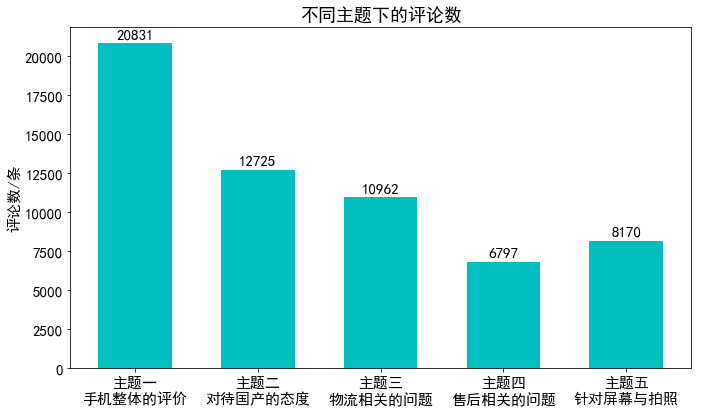

In [7]:
temp=dict(all_comments['所属主题'].value_counts())
names=['主题一','主题二','主题三','主题四','主题五']
labels=['主题一\n手机整体的评价','主题二\n对待国产的态度','主题三\n物流相关的问题','主题四\n售后相关的问题','主题五\n针对屏幕与拍照']
x=np.arange(len(labels))
fig,ax=plt.subplots(figsize=(10,6))
r1=ax.bar(x,[temp[i] for i in names],align='center',color='c',width=0.6)
ax.set_ylabel('评论数/条')
ax.set_title('不同主题下的评论数')
ax.set_xticks(x)
ax.set_xticklabels(labels)
autolabel(r1)
fig.tight_layout()
plt.savefig('./data/pictures/不同主题下的评论数.jpg')
plt.show()

### 情感分析

#### 基于词典的情感分析

定义词典（否定词词典、程度副词词典、正负面情感词词典、表情）、定义各个词典的得分函数

In [8]:
# 所有词典
data=[]
for w in ['most','over','very','more','little','low','pos','neg','not']:
    with open(f'./data/sentiment/{w}.txt','r',encoding='utf-8') as f:
        temp=[i.strip() for i in f.readlines()]
        for k in temp:
            if k not in data:
                data.append(k)
pd.Series(data).to_csv('./data/sentiment/all_words.txt',index=False,encoding='utf-8')
# 否定词
f=open('./data/sentiment/not.txt',encoding='utf-8')
all_not=[i.strip() for i in f.readlines()]
f.close()
# 程度副词
all_degree=[]
most=[]
over=[]
very=[]
more=[]
little=[]
low=[]
for w in ['most','over','very','more','little','low']:
    with open(f'./data/sentiment/{w}.txt','r',encoding='utf-8') as f:
        temp=[i.strip() for i in f.readlines()]
        all_degree=all_degree+temp
        if w == 'most':
            most=most+temp
        elif w == 'over':
            over=over+temp
        elif w == 'very':
            very=very+temp
        elif w == 'more':
            more=more+temp
        elif w == 'little':
            little=little+temp
        elif w == 'low':
            low=low+temp
# 正、负面情感词
all_sentiment=[]
pos=[]
neg=[]
for w in ['pos','neg']:
    with open(f'./data/sentiment/{w}.txt','r',encoding='utf-8') as f:
        temp=[i.strip() for i in f.readlines()]
        all_sentiment=all_sentiment+temp
        if w == 'pos':
            pos=pos+temp
        elif w == 'neg':
            neg=neg+temp
# 表情
good=[
    '👍🏻','😍','😊','😄','❤️','👍','👏','💪','🐮','😁',
    '🤗','👌🏻','😀️','🤣','🥳','😜','🤪','🉑️','🐂','🍺',
    '👌','🌝','😘','❤','💋','😏','✊','🉐','😃','🌹',
    '☝️','😋','🤓','💯','✌','🥊','💙','💛','😝','💕',
    '🌈','😉','😇','⭐️','😎','😚','✔','💞','👊','✨',
    '😙','😗','🤑','🥰','😽','☺️','💖','💐','💑','😛',
    '👄','🤩','💗','🌸','😺','🙆','😻','☀️','💝','🤝',
    '🎉','🏆','🖐','♥️','🏅','🥇','🤭','💏','✋','🌞'
]
bad=[
    '😂','😱','😞','😩','😫','😖','😡','😐','🙃','💔',
    '😬','😓','😠','😤','😪','😑','😭','🤨','👎','🖕',
    '😔','😴','🙄','💩','👎🏿','😥','❌','😌','🤷','😅',
    '🤕','☹️','😳','😣','😶','😰','😕','😹','😒','😟','🤯'
]
# 加载词典
jieba.load_userdict('./data/sentiment/all_words.txt')

# 定义函数
def get_degree(word):
    if word in most:
        return 2
    elif word in over:
        return 1.7
    elif word in very:
        return 1.4
    elif word in more:
        return 1.1
    elif word in little:
        return 0.8
    elif word in low:
        return 0.5

Building prefix dict from the default dictionary ...
Dumping model to file cache D:/python3.7/jieba.cache
Loading model cost 1.596 seconds.
Prefix dict has been built succesfully.


计算情感得分

In [9]:
# 加载数据
f=open('./data/LDA主题模型结果.csv',encoding='utf-8')
all_comments=pd.read_csv(f)
f.close()
all_comments=all_comments.fillna('')

result=[] # 存储所有评论的得分结果
yuanshi=[] # 存储原来的情感得分，用来画箱线图
for eachone in all_comments['原评论'].values.tolist():
    score=[] # 存储当前评论的得分
    s=re.sub('&[a-zA-Z]+;','',eachone)
    s=re.sub('[,.;! ，。；！]|<br/>','$',s)
    data=[i for i in s.split('$') if i != '']
    for juzi in data:
        for j in emoji.emoji_lis(juzi):
            # 计算表情得分
            _=j['emoji']
            if _ in good:
                score.append(2)
            if _ in bad:
                score.append(-2)
        cao=re.sub('[^\u4e00-\u9fa50-9a-zA-Z]+','',juzi)
        temp1=jieba.cut(cao,HMM=False) # 精确模式，并且取消HMM新词发现
        temp=[i for i in temp1]
        for i,each in enumerate(temp):
            if each in all_sentiment:
                if each in pos:
                    # 正面情感词得分计算
                    a=2
                    tem1=temp[i-1] if i != 0 else None
                    if tem1 in all_degree:
                        # 否定词在程度副词之前
                        b=get_degree(tem1)
                        tem2=temp[i-2] if i>=2 else None
                        if tem2 in all_not:
                            c=0.5
                            score.append(a*b*c)
                        else:
                            score.append(a*b)
                    if tem1 in all_not:
                        # 否定词在程度副词之后
                        c=-1
                        tem2=temp[i-2] if i>=2 else None
                        if tem2 in all_degree:
                            b=get_degree(tem2)
                            score.append(a*b*c)
                        else:
                            score.append(a*c)
                    else:
                        # 即没有程度副词又没有否定词
                        score.append(a)
                if each in neg:
                    # 负面情感词得分计算
                    a=-2
                    tem1=temp[i-1] if i != 0 else None
                    if tem1 in all_degree:
                        # 否定词在程度副词之前
                        b=get_degree(tem1)
                        tem2=temp[i-2] if i>=2 else None
                        if tem2 in all_not:
                            c=0.5
                            score.append(a*b*c)
                        else:
                            score.append(a*b)
                    if tem1 in all_not:
                        # 否定词在程度副词之后
                        c=-1
                        tem2=temp[i-2] if i>=2 else None
                        if tem2 in all_degree:
                            b=get_degree(tem2)
                            score.append(a*b*c)
                        else:
                            score.append(a*c)
                    else:
                        # 即没有程度副词又没有否定词
                        score.append(a)
            if each in ['?','？']:
                # 若为问号则情感得分减2
                score.append(-2)
            else:
                continue
    pp=sum(score)
    yuanshi.append(pp)
    if pp >= 20:
        result.append(20)
    elif pp <= -20:
        result.append(-20)
    else:
        result.append(pp)
all_comments['dict_score']=result

查看原始情感得分的箱线图

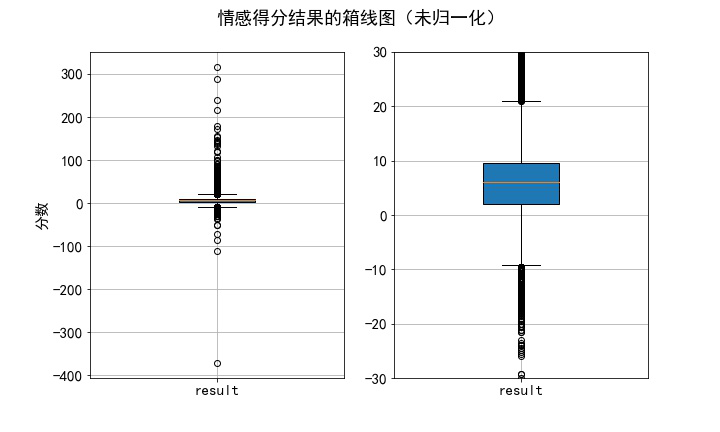

In [10]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].boxplot(yuanshi,widths=0.3,patch_artist=True,labels=['result'])
ax[1].boxplot(yuanshi,widths=0.3,patch_artist=True,labels=['result'])
ax[1].set_ylim((-30,30))
ax[0].grid(True)
ax[0].set_ylabel('分数')
ax[1].grid(True)
fig.suptitle('情感得分结果的箱线图（未归一化）')
fig.savefig('情感得分结果的箱线图（未归一化）.jpg')
plt.show()

基于词典的情感得分结果（柱状图）

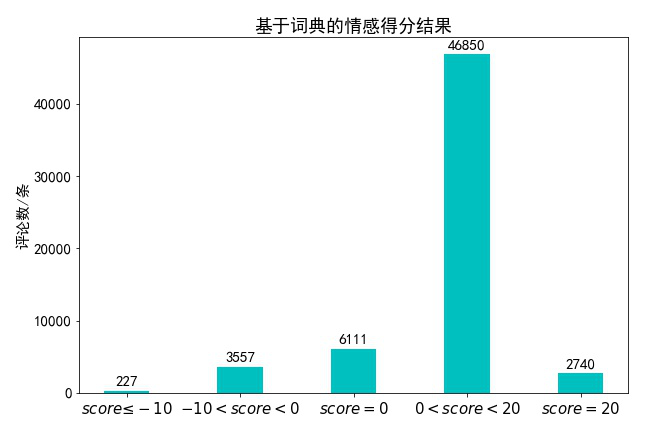

In [11]:
def subdivision(x):
    if x<=-10:
        return '$score≤-10$'
    elif -10<x<0:
        return '$-10<score<0$'
    elif x==0:
        return '$score=0$'
    elif 0<x<20:
        return '$0<score<20$'
    elif x==20:
        return '$score=20$'
temp=dict(all_comments['dict_score'].apply(lambda x:subdivision(x)).value_counts())
labels=['$score≤-10$','$-10<score<0$','$score=0$','$0<score<20$','$score=20$']
plt.figure(figsize=(9,6))
a=plt.bar(labels,[temp[i] for i in labels],width=0.4,color='c')
autolabel(a)
plt.title('基于词典的情感得分结果')
plt.ylabel('评论数/条')
plt.tight_layout()
plt.savefig('./data/pictures/基于词典的情感得分结果.jpg')
plt.show()

归一化处理（最大-最小值）

$score^`=\frac{score-minA}{maxA-minA}$

In [12]:
da=max(result) # 最大值
xiao=min(result) # 最小值
gyh_result=[(i-xiao)/(da-xiao) for i in result]
all_comments['gyh_score']=gyh_result

根据归一化后的分数划分正、负面情感（大于0.5为正面，小于等于0.5为负面）

In [13]:
all_comments['dict_sentiment']=all_comments['gyh_score'].apply(lambda x:'正面' if x>0.5 else '负面')

基于词典的情感倾向结果（正、负面占比饼图）

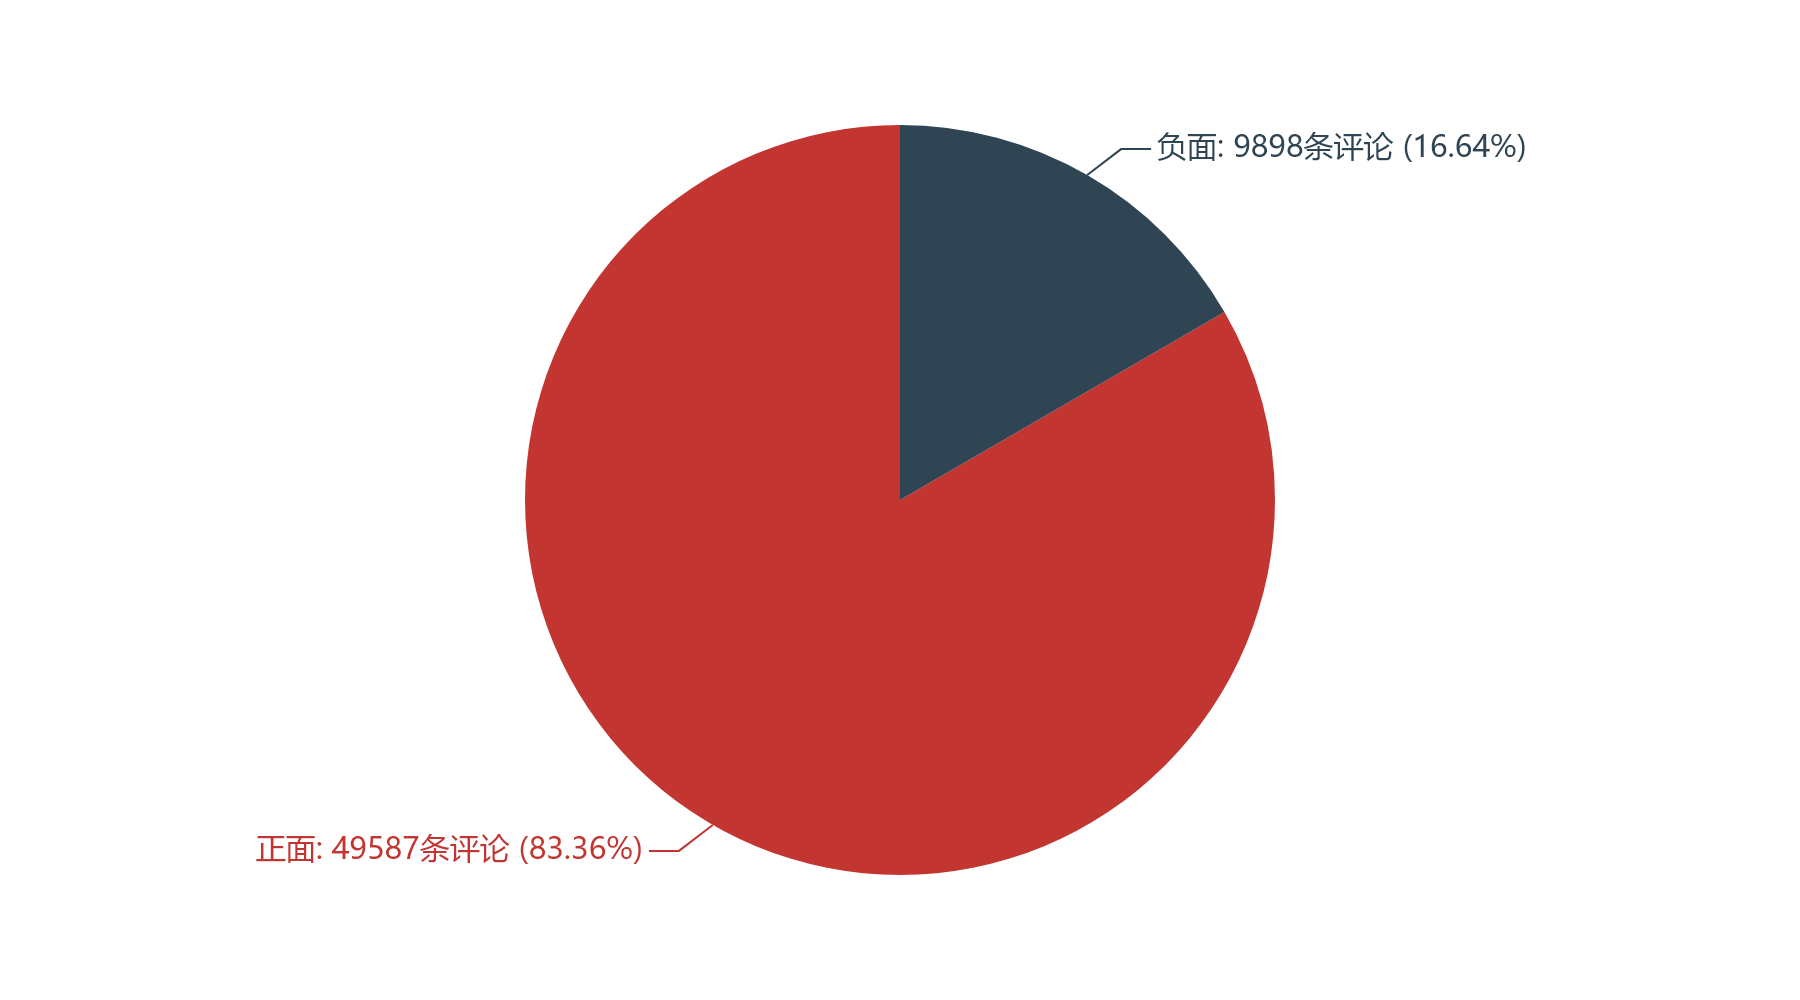

In [14]:
temp=all_comments['dict_sentiment'].value_counts()
c=Pie()
c.add(series_name='',data_pair=temp.items(),is_clockwise=False)
c.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}条评论 ({d}%)",font_size=15))
c.render_notebook()

保存图片

In [15]:
make_snapshot(snapshot,c.render(),'./data/pictures/基于词典的情感倾向饼图.png',is_remove_html=True)

保存结果

In [16]:
all_comments.to_csv('./data/基于词典的情感倾向.csv',index=False,encoding='utf_8_sig')

#### 基于snownlp库的情感分析
将snownlp的停用词表改为jieba的停用词表

In [17]:
from snownlp import normal
f=open('./data/stoplist.txt','r',encoding='utf-8')
stoplist=[i.strip() for i in f.readlines()]
f.close()
normal.stop=stoplist

##### 纯snownlp的情感分析

In [18]:
all_comments=pd.read_csv('./data/sentences.txt',header=None,names=['原评论'])
all_comments['纯snownlp语料的得分']=all_comments['原评论'].apply(lambda x:SnowNLP(x).sentiments)
all_comments['纯snownlp语料的情感倾向']=all_comments['纯snownlp语料的得分'].apply(lambda x:'正面' if x>0.5 else '负面')

##### 增加训练语料的snownlp情感分析
人工选出100条正面评价和100条负面评价，并添加到snownlp自带的语料中，重新训练一个朴素贝叶斯分类器

In [19]:
all_select=[]
select_neg=[] # 存储负面评价
select_pos=[] # 存储正面评价
while True:
    comment=all_comments.sample(1)['原评论'].values[0] # 在所有评论中随机查看一条，然后人工打标签
    print(f'原评论：{comment}')
    print('')
    print('若为正面输入1，负面输入2，跳过这条直接回车，输入exit退出程序')
    label=input()
    if label == '1':
        if comment not in all_select:
            all_select.append(comment)
            select_pos.append(comment)
        else:
            print('重复了！')
    elif label == '2':
        if comment not in all_select:
            all_select.append(comment)
            select_neg.append(comment)
        else:
            print('重复了！')
    elif label == '':
        print('-'*135)
        continue
    elif label == 'exit':
        break
    print(f'目前正面有{len(select_pos)}条\n目前负面有{len(select_neg)}条')
    print('-'*135)

# 与snownlp的正负面语料合并
snow_neg=pd.read_csv('./data/neg.txt',sep='\n',header=None,names=['snownlp负面语料'])
snow_pos=pd.read_csv('./data/pos.txt',sep='\n',header=None,names=['snownlp正面语料'])
for i in snow_neg['snownlp负面语料'].values:
    select_neg.append(i)
for i in snow_pos['snownlp正面语料'].values:
    select_pos.append(i)

# 最后将合并后的结果保存下来
pd.Series(select_neg).to_csv('./data/select_neg.txt',index=False,encoding='utf-8')
pd.Series(select_pos).to_csv('./data/select_pos.txt',index=False,encoding='utf-8')

重新训练模型，并保存模型

In [20]:
sentiment.train('./data/select_neg.txt','./data/select_pos.txt')
sentiment.save('./data/sentiment/select_sentiment.marshal')

加载模型，计算情感得分，划分情感倾向

In [21]:
sentiment.load('./data/sentiment/select_sentiment.marshal')
all_comments['增加训练语料的得分']=all_comments['原评论'].apply(lambda x:SnowNLP(x).sentiments)
all_comments['增加训练语料的情感倾向']=all_comments['增加训练语料的得分'].apply(lambda x:'正面' if x>0.5 else '负面')

##### 将纯snownlp的情感分析与增加语料后的snownlp情感分析进行比较

两者划分的情感倾向不同的那些评论

In [22]:
all_comments[(all_comments.增加训练语料的情感倾向!=all_comments.纯snownlp语料的情感倾向)==True]

,原评论,纯snownlp语料的得分,纯snownlp语料的情感倾向,增加训练语料的得分,增加训练语料的情感倾向
181,发货速度很快晚上下单第二天就到了，包装也很好,0.476388,负面,0.506806,正面
240,挺不错的，用着还可以！又买了别的型号的！,0.604862,正面,0.333179,负面
306,很好用，不错，在疫情期间快递也给力。,0.341382,负面,0.886303,正面
328,才用一个礼拜，微信就出现，无响应。,0.539168,正面,0.480992,负面
354,還不知道如何！,0.555556,正面,0.450549,负面
363,正在用，几天后追加评价,0.528492,正面,0.270740,负面
364,给媳妇买的。 非常满意！,0.264269,负面,0.638896,正面
377,快递非常快，晚上购买第二天中午就到了太给力了，手机不错。,0.197790,负面,0.590603,正面
408,一直用华为习惯好评,0.374071,负面,0.502387,正面
419,宝贝收到了，物流太给力了！手机也好，太满意了，我还是第一次在网上买手机呢！没有失望，大爱,0.248883,负面,0.624990,正面


保存情感分析结果

In [23]:
all_comments.to_csv('./data/原始语料与增加训练语料的对比.csv',index=False,encoding='utf_8_sig')

#### 基于词典和snownlp的情感分析
基本流程：1.首先基于词典的情感分析得出结果；
       2.将情感得分等于20分的评论添加进snownlp的原始正面语料，而将小于等于-10分的添加进snownlp的原始负面语料；
       3.将合并后的正负面语料重新训练一个情感倾向模型；
       4.将得到的模型应用在得分为0分的评论，将其重新划分正负面；
       5.得出最终的情感倾向结果。

In [24]:
# 加载前面基于词典的情感分析结果
f=open('./data/基于词典的情感倾向.csv',encoding='utf-8')
all_comments=pd.read_csv(f)
f.close()
all_comments=all_comments.fillna('')

In [25]:
big_neg=[] # 负面
big_pos=[] # 正面
# snownlp原始负面语料
with open('./data/neg.txt','r',encoding='utf-8') as f:
    temp=[i.strip() for i in f.readlines()]
    for k in temp:
        big_neg.append(k)
# snownlp原始正面语料
with open('./data/pos.txt','r',encoding='utf-8') as f:
    temp=[i.strip() for i in f.readlines()]
    for k in temp:
        big_pos.append(k)
# 小于等于-10分的评论
for i in all_comments[(all_comments.dict_score<=-10)==True]['原评论'].values:
    if i not in big_neg:
        big_neg.append(i)
# 等于20分的评论
for i in all_comments[(all_comments.dict_score==20)==True]['原评论'].values:
    if i not in big_pos:
        big_pos.append(i)
# 将新的正负面语料保存
pd.Series(big_neg).to_csv('./data/big_neg.txt',index=False,encoding='utf-8')
pd.Series(big_pos).to_csv('./data/big_pos.txt',index=False,encoding='utf-8')

In [26]:
# 训练模型、保存模型
sentiment.train('./data/big_neg.txt','./data/big_pos.txt')
sentiment.save('./data/sentiment/big_sentiment.marshal')

In [27]:
# 应用于所有评论，得出新的情感倾向
sentiment.load('./data/sentiment/big_sentiment.marshal')
all_comments['new_score']=all_comments['原评论'].apply(lambda x:SnowNLP(x).sentiments)
all_comments['new_sentiment']=all_comments['new_score'].apply(lambda x:'正面' if x>0.5 else '负面')

In [28]:
# 重新划分0分的那些评论，得出最终情感倾向结果，并保存最终情感倾向的结果
ind=all_comments[all_comments['dict_score'].map(lambda x : x==0)].index
d=all_comments['dict_sentiment'].values
n=all_comments['new_sentiment'].values
for i in range(len(ind)):
    if i in ind:
        all_comments.loc[i,'最终情感']=n[i]
    else:
        all_comments.loc[i,'最终情感']=d[i]
# 保存结果
all_comments.to_csv('./data/最终的情感倾向.csv',index=False,encoding='utf_8_sig')

将最终的情感倾向结果可视化（饼图）

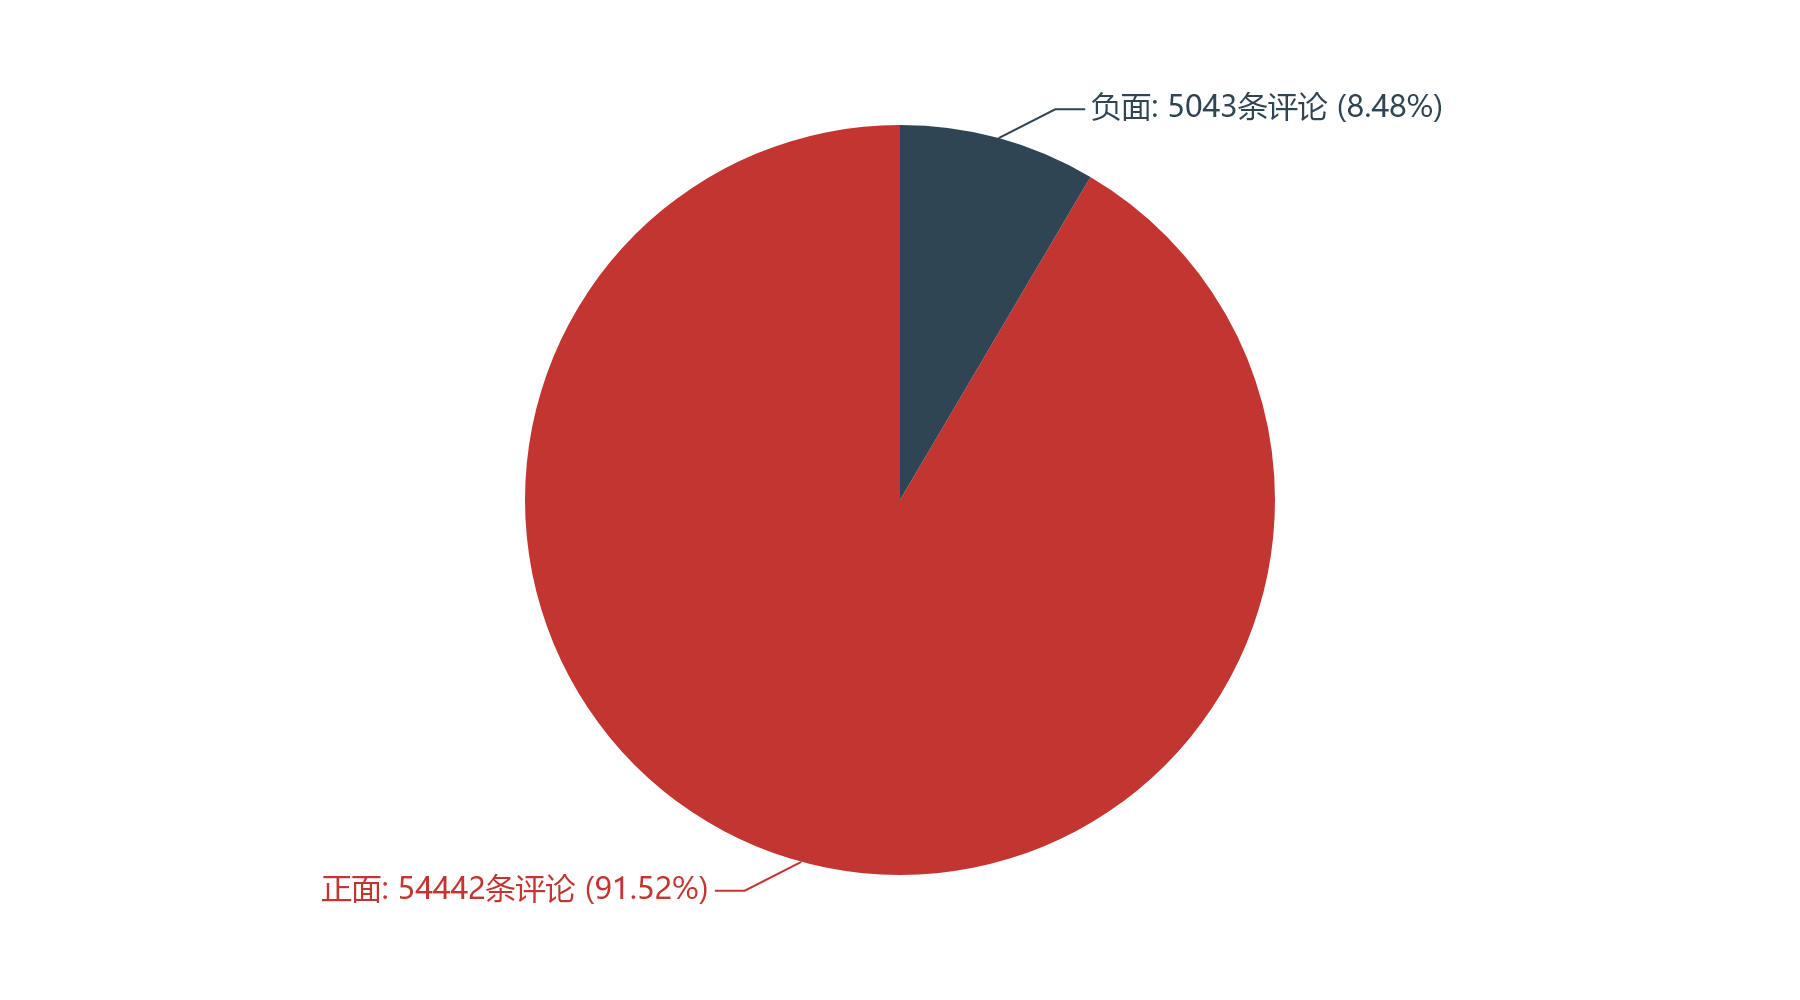

In [29]:
temp=all_comments['最终情感'].value_counts()
c=Pie()
c.add(series_name='',data_pair=temp.items()),is_clockwise=False)
c.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}条评论 ({d}%)",font_size=15))
c.render_notebook()

将饼图进行保存

In [30]:
make_snapshot(snapshot,c.render(),'./data/pictures/最终情感倾向饼图.png',is_remove_html=True)

#### 将前面得到的主题模型结果和最终的情感倾向结果进行结合，可视化输出不同主题下的情感倾向（柱状图）

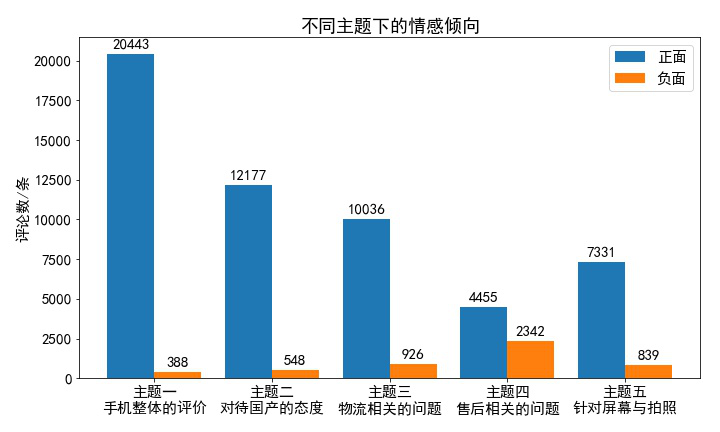

In [31]:
# 加载最终情感倾向结果
f=open('./data/最终的情感倾向.csv',encoding='utf-8')
all_comments=pd.read_csv(f)
f.close()
all_comments=all_comments.fillna('')

temp={}
for key,value in all_comments[all_comments['最终情感']=='正面']['所属主题'].value_counts().items():
    temp[key]=[value]
for key,value in all_comments[all_comments['最终情感']=='负面']['所属主题'].value_counts().items():
    temp[key].append(value)
names=['主题一','主题二','主题三','主题四','主题五']
labels=['主题一\n手机整体的评价','主题二\n对待国产的态度','主题三\n物流相关的问题','主题四\n售后相关的问题','主题五\n针对屏幕与拍照']
x=np.arange(len(labels))
width=0.4
fig,ax=plt.subplots(figsize=(10,6))
r1=ax.bar(x-width,[temp[i][0] for i in names],width,label='正面',align='edge')
r2=ax.bar(x,[temp[i][1] for i in names],width,label='负面',align='edge')
ax.set_ylabel('评论数/条')
ax.set_title('不同主题下的情感倾向')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(r1)
autolabel(r2)
fig.tight_layout()
plt.savefig('./data/pictures/不同主题下的情感倾向.jpg')
plt.show()

主题一中随机的5条负面评价

In [32]:
a=all_comments['所属主题'].map(lambda x:x=='主题一')
b=all_comments['最终情感'].map(lambda x:x=='负面')
all_comments[a&b].sample(5)['原评论']

3109               可以一颗星都不给吗？差评，颜色不喜欢还不给换这个颜色是真的不喜欢，跟图片不一样
2270     什么都好 就是这个屏幕分辨率是怎么回事？不管是拍照 拍视频 还是用播放器看视频都像失真一样 ...
10207      用了五六天，发现电池不经用，就是看点新闻查点资料一天电就没了，如果看视频，电池可能都不够一天一
57345           一天充电充满的话要充2次，看电视就看两集就去了一半电，充倒是很快，就是电池太不耐用了
33389                                   6666摄像头牛逼的一塌糊涂，不解释
Name: 原评论, dtype: object

主题二中随机的5条负面评价

In [33]:
a=all_comments['所属主题'].map(lambda x:x=='主题二')
b=all_comments['最终情感'].map(lambda x:x=='负面')
all_comments[a&b].sample(5)['原评论']

6714                             华为手机是真的辣鸡，吹嘘的那么#，真是谁买谁知道。
44656    已经不知道是第几部HUAWEI手机了，但这部手机代表着以后会不会再选择HUAWEI，因为之前...
35861                        本来想买个天空色，太难抢了，只好用黑色了。支持华为支持国货
32806                               暗光拍摄，没有朋友，天秀，太恐怖了，支持华为
5784                          手机买回来一天 喇叭沙了 哈 不是不支持国产 而是好失望
Name: 原评论, dtype: object

主题三中随机的5条负面评价

In [34]:
a=all_comments['所属主题'].map(lambda x:x=='主题三')
b=all_comments['最终情感'].map(lambda x:x=='负面')
all_comments[a&b].sample(5)['原评论']

12511                            多次购买，就是发货慢一些，新品产能跟不上，情有可原
7520     4月11日的订单，赠送延时补偿一项，显示4月12日交货给客户，付完全款，订单及物流信息显示2...
32740                                            发货太慢，各种推辞
5584           店家发货错误，我购买的手机是8G+256G的手机，给我发的是8G+128G的手机！！！
59456                    快递垃圾的一匹 送货送的慢不按时 退货也不按时 慢慢我就放弃华为了
Name: 原评论, dtype: object

主题四中随机的5条负面评价

In [35]:
a=all_comments['所属主题'].map(lambda x:x=='主题四')
b=all_comments['最终情感'].map(lambda x:x=='负面')
all_comments[a&b].sample(5)['原评论']

5761                      诱导顾客有赠品，实则没有，真的很差，手机倒是还不错，消费体验不佳
6052     别的都挺好，这是第一次发现在线上买东西不如线下，线下实体店送一堆的配件，价格还跟线上一样，感...
13163                                  手机不错，差评给客服，说到做不到！！！
56004                                 买来两天就降价500，一次失望的购物，哎
19900    抢了两个月，终于到手了。颜色没有图片上的艳，最主要的是手机太裸了，连个保护膜都没有，到了还要...
Name: 原评论, dtype: object

主题五中随机的5条负面评价

In [36]:
a=all_comments['所属主题'].map(lambda x:x=='主题五')
b=all_comments['最终情感'].map(lambda x:x=='负面')
all_comments[a&b].sample(5)['原评论']

37085    用了几天和P20 PRO差别不是很大，远距离拍照效果不好，像素模糊，只是简单的图片放大和裁剪...
14886    来冲这款手机拍照功能买的，和同事一人买了一台，可是拍照和拍视频的效果非常不理想，特别是拍抖音...
44786                                        有点失望，特别拍照不如预期
46895                                       夜视仪+望远镜，一点不带假的
5987       拍照画质粗糙，看视频与苹果6对比都落后，画质不清晰，发暗。没几天就便宜了500 ，一点不保值！
Name: 原评论, dtype: object